In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import readout_explained_var

from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions_temp = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
sessions = pd.DataFrame()
sessions["basepath"] = sessions_temp.basepath.unique()
sessions

,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
108,Z:\Data\FujisawaS\EE\EE0705fm
109,Z:\Data\FujisawaS\EE\EE0706fm
110,Z:\Data\FujisawaS\EE\EE0708fm
111,Z:\Data\HMC1\day12


## main analysis

In [162]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr_w_theta"
)

batch_analysis.run(
    sessions,
    save_path,
    readout_explained_var.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)

100%|██████████| 113/113 [00:06<00:00, 18.25it/s]


In [163]:
pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)


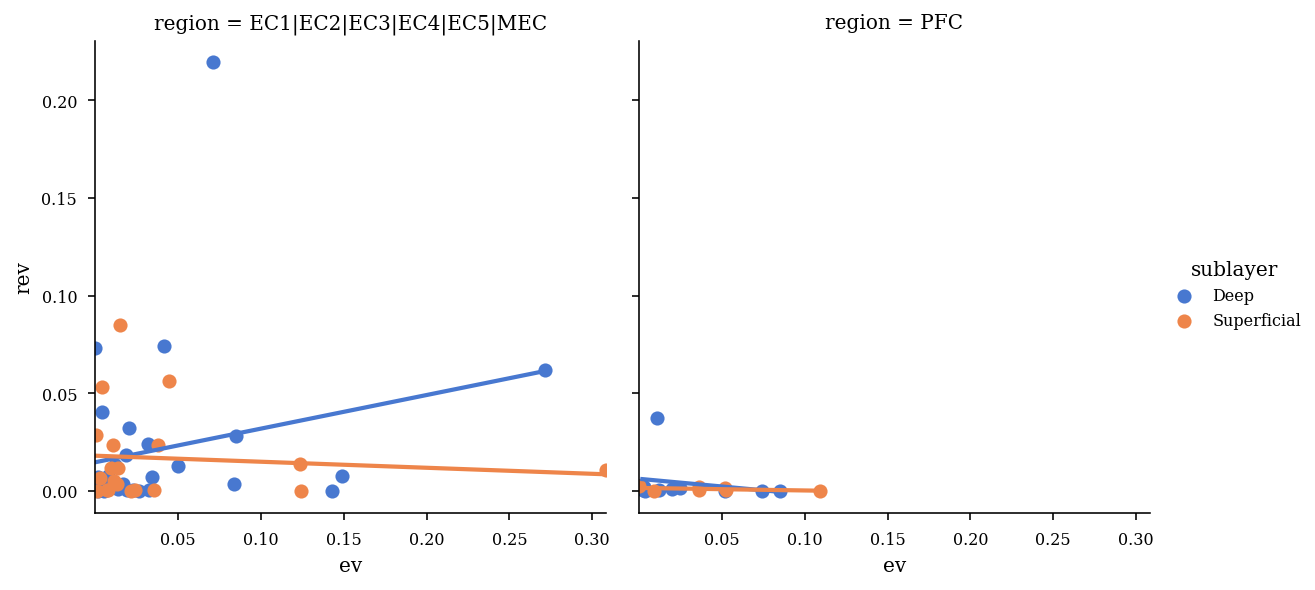

In [164]:
sns.lmplot(x="ev", y="rev", col="region", hue="sublayer", data=ev_df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

In [165]:
ev_df

,region,sublayer,ev,rev,n_ca1,n_target,basepath
0,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.016938,0.003553,12.0,10.0,Z:\Data\AYAold\AYA7\day19
1,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.007207,0.000961,17.0,38.0,Z:\Data\AYAold\AYA7\day20
2,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.012089,0.013393,19.0,50.0,Z:\Data\AYAold\AYA7\day24
3,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.013088,0.003740,7.0,50.0,Z:\Data\AYAold\AYA7\day24
4,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.000847,0.002913,34.0,79.0,Z:\Data\AYAold\AYA9\day12
...,...,...,...,...,...,...,...
64,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.013593,0.011919,18.0,6.0,Z:\Data\Kenji\ec016.532_540
65,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.271474,0.062178,8.0,7.0,Z:\Data\Kenji\ec016.577_590
66,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.035265,0.000508,44.0,7.0,Z:\Data\Kenji\ec016.577_590
67,PFC,Deep,0.010959,0.037213,19.0,13.0,Z:\Data\ORproject\OR18\day1


In [166]:
df_long = pd.DataFrame()
df_long["ev"] = np.hstack([ev_df.ev.values, ev_df.rev.values])
df_long["ev_labels"] = np.hstack([["ev"]*ev_df.ev.shape[0], ["rev"]*ev_df.rev.shape[0]])
df_long["region"] = np.hstack([ev_df.region.values, ev_df.region.values])
df_long["sublayer"] = np.hstack([ev_df.sublayer.values, ev_df.sublayer.values])
df_long["n_ca1"] = np.hstack([ev_df.n_ca1.values, ev_df.n_ca1.values])
df_long["n_target"] = np.hstack([ev_df.n_target.values, ev_df.n_target.values])
df_long["basepath"] = np.hstack([ev_df.basepath.values, ev_df.basepath.values])


df_long

,ev,ev_labels,region,sublayer,n_ca1,n_target,basepath
0,0.016938,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,12.0,10.0,Z:\Data\AYAold\AYA7\day19
1,0.007207,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,17.0,38.0,Z:\Data\AYAold\AYA7\day20
2,0.012089,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,19.0,50.0,Z:\Data\AYAold\AYA7\day24
3,0.013088,ev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,7.0,50.0,Z:\Data\AYAold\AYA7\day24
4,0.000847,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,34.0,79.0,Z:\Data\AYAold\AYA9\day12
...,...,...,...,...,...,...,...
133,0.011919,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,18.0,6.0,Z:\Data\Kenji\ec016.532_540
134,0.062178,rev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,8.0,7.0,Z:\Data\Kenji\ec016.577_590
135,0.000508,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,44.0,7.0,Z:\Data\Kenji\ec016.577_590
136,0.037213,rev,PFC,Deep,19.0,13.0,Z:\Data\ORproject\OR18\day1


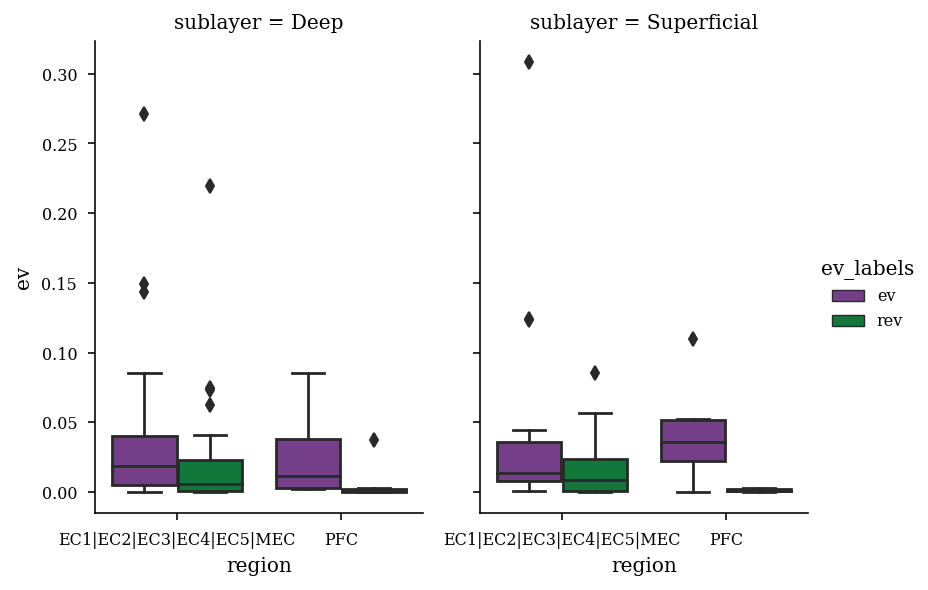

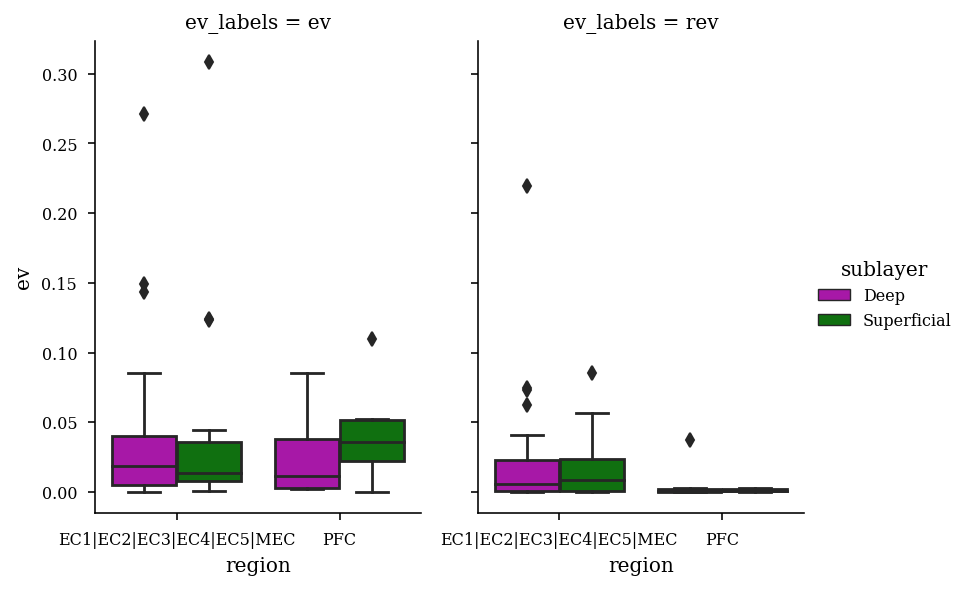

In [167]:
g = sns.catplot(x="region", y="ev",
                hue="ev_labels", col="sublayer",
                data=df_long, kind="box",
                height=4, aspect=.7)
sns.despine()
plt.show()

g = sns.catplot(x="region", y="ev",
                hue="sublayer", col="ev_labels",
                data=df_long, kind="box",palette=["m", "g"],
                height=4, aspect=.7)

# g = sns.catplot(x="region", y="ev",
#                 hue="sublayer", col="ev_labels",
#                 data=df_long,palette=["m", "g"],
#                 height=4, aspect=.7)
sns.despine()
plt.show()

In [168]:
ev_df.basepath.value_counts(), ev_df.region.value_counts() 

ev_df["ev_norm"] = ev_df.ev - ev_df.rev

In [169]:
df_wide = pd.pivot(
    ev_df, index=["region","basepath"], columns="sublayer", values=["ev","rev"]
).reset_index()
df_wide
df_wide["deep_ev_norm"] = df_wide["ev"]["Deep"] - df_wide["rev"]["Deep"]
df_wide["sup_ev_norm"] = df_wide["ev"]["Superficial"] - df_wide["rev"]["Superficial"]
df_wide
# ratio between deep and sup normed ev (offset by 1 for ratio)
df_wide["deep_sup_ev_ratio_ev_norm"] = ((df_wide["deep_ev_norm"]+1) - (df_wide["sup_ev_norm"]+1)) / ((df_wide["deep_ev_norm"]+1) + (df_wide["sup_ev_norm"]+1))

df_wide["deep_sup_ev_ratio"] = (df_wide["ev"]["Deep"] - df_wide["ev"]["Superficial"]) / (df_wide["ev"]["Deep"] + df_wide["ev"]["Superficial"])

df_wide["constant"] = 1
df_wide.head(10)

region                   basepath        ev  \
sublayer                                                          Deep   
0         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day19  0.016938   
1         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day20  0.007207   
2         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day24  0.012089   
3         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day12  0.000847   
4         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day15  0.005305   
5         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day16  0.002853   
6         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day17  0.020297   
7         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day10  0.083515   
8         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day12  0.032461   
9         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day13  0.013848   

                           rev             deep_ev_norm sup_ev_norm  \
sublayer Superficial      Deep Superficial                            
0                NaN  0.003553         NaN     0.013385         NaN   
1                NaN  0.000961         NaN     0.006246         NaN   
2           0.013088  0.013393    0.003740    -0.001304    0.009348   
3           0.000772  0.002913    0.000299    -0.002066    0.000473   
4           0.007041  0.000024    0.000846     0.005282    0.006195   
5           0.009611  0.003772    0.011768    -0.000919   -0.002157   
6           0.010472  0.032425    0.023842    -0.012127   -0.013371   
7           0.124375  0.003433    0.000051     0.080082    0.124324   
8           0.023744  0.000365    0.000795     0.032096    0.022949   
9           0.021825  0.001005    0.000195     0.012844    0.021629   

         deep_sup_ev_ratio_ev_norm deep_sup_ev_ratio constant  
sublayer                                                       
0                              NaN               NaN        1  
1                              NaN               NaN        1  
2                        -0.005305         -0.039682        1  
3                        -0.001270          0.046421        1  
4                        -0.000454         -0.140567        1  
5                         0.000620         -0.542201        1  
6                         0.000630          0.319339        1  
7                        -0.020070         -0.196547        1  
8                         0.004451          0.155087        1  
9                        -0.004318         -0.223588        1

In [170]:
from scipy import stats
x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

Ttest_1sampResult(statistic=-0.2277021375250909, pvalue=0.8231696624118281)
Ttest_1sampResult(statistic=-0.5054751125918933, pvalue=0.6312525605859383)
Ttest_1sampResult(statistic=-0.5815304243792762, pvalue=0.570128462949185)
Ttest_1sampResult(statistic=0.5946388323611123, pvalue=0.5738088689124732)


In [171]:
import statsmodels.formula.api as smf
results = smf.ols('deep_sup_ev_ratio_ev_norm ~ region', data=df_wide).fit()
print(results.summary())



                                OLS Regression Results                               
Dep. Variable:     deep_sup_ev_ratio_ev_norm   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                 -0.050
Method:                        Least Squares   F-statistic:                  0.002250
Date:                       Tue, 12 Jul 2022   Prob (F-statistic):              0.963
Time:                               17:18:24   Log-Likelihood:                 47.816
No. Observations:                         22   AIC:                            -91.63
Df Residuals:                             20   BIC:                            -89.45
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [172]:
results = smf.ols('deep_sup_ev_ratio ~ region', data=df_wide).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      deep_sup_ev_ratio   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.5650
Date:                Tue, 12 Jul 2022   Prob (F-statistic):              0.461
Time:                        17:18:29   Log-Likelihood:                -14.787
No. Observations:                  22   AIC:                             33.57
Df Residuals:                      20   BIC:                             35.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0798      0.128     -0.622

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=9.626e-01 stat=-4.743e-02


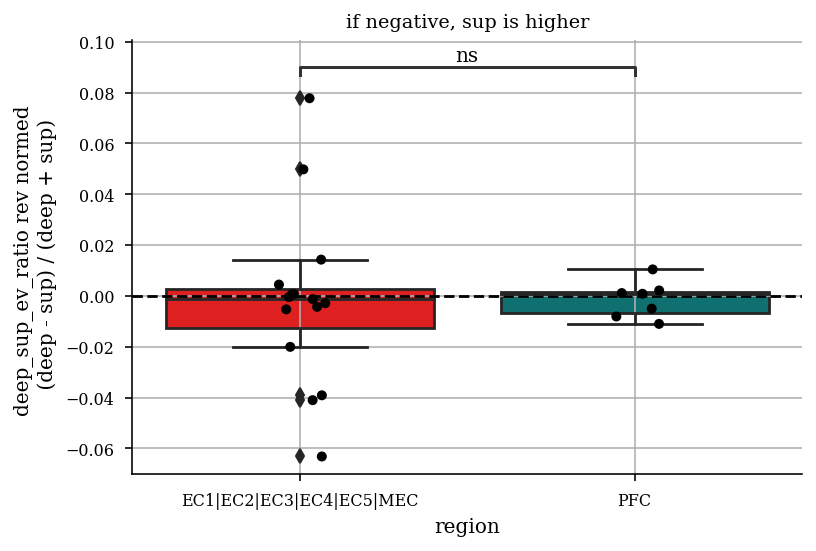

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=4.610e-01 stat=-7.517e-01


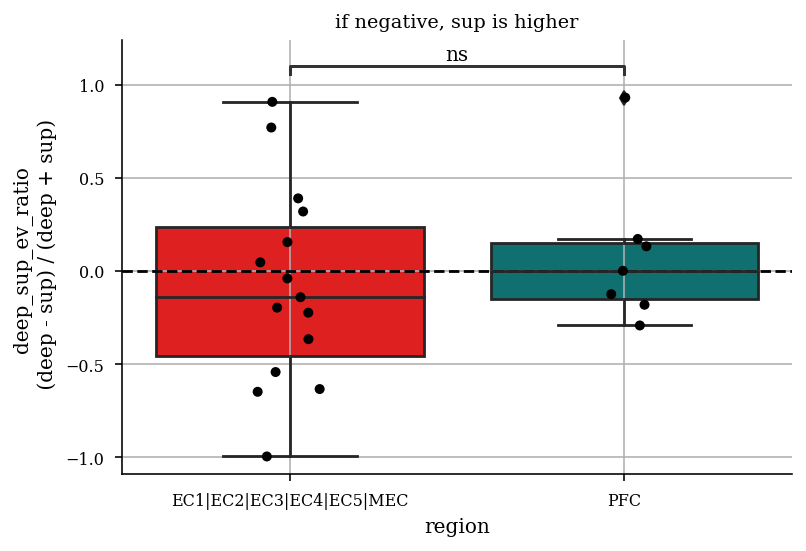

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=5.613e-01 stat=-1.117e+00
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-2.995e-01


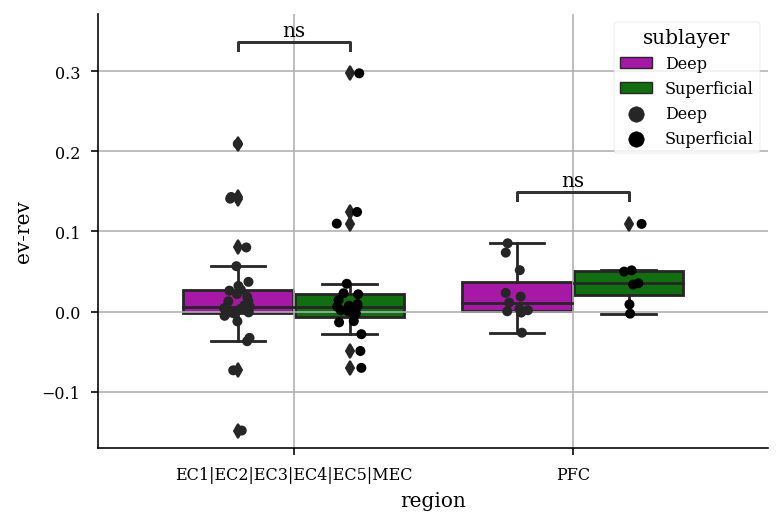

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=6.576e-01 stat=-1.007e+00
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-7.259e-02


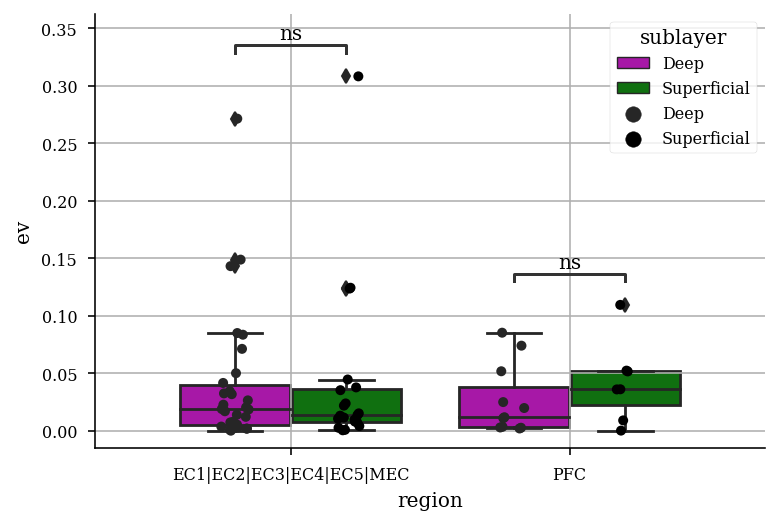

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=9.334e-01 stat=7.456e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=4.453e-01


(<AxesSubplot:xlabel='region', ylabel='rev'>,
  <statannot.StatResult.StatResult at 0x270159ba8b0>])

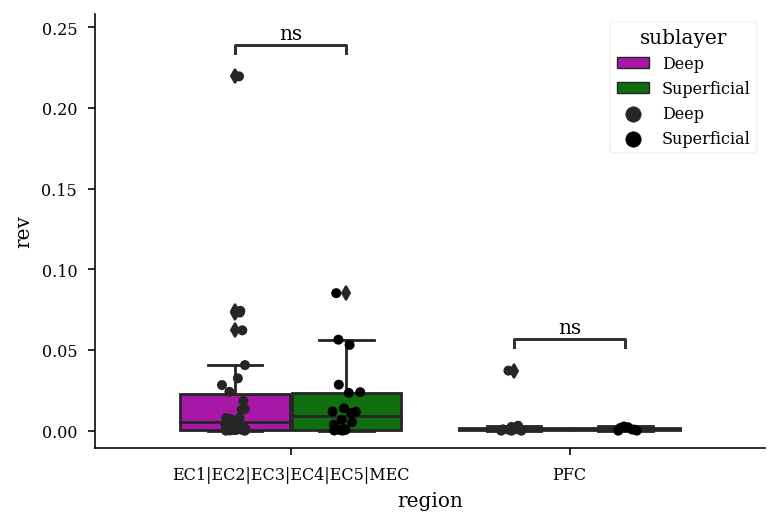

In [173]:
from statannot import add_stat_annotation

sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k')
sns.despine()
plt.ylabel("deep_sup_ev_ratio rev normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="deep_sup_ev_ratio", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio", x="region",color='k',
            data=df_wide,dodge=True)
sns.despine()
plt.ylabel("deep_sup_ev_ratio \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()


sns.boxplot(y="ev_norm", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="ev_norm", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.ylabel('ev-rev')
plt.grid()
box_pairs=[(("EC1|EC2|EC3|EC4|EC5|MEC", "Deep"), ("EC1|EC2|EC3|EC4|EC5|MEC", "Superficial")),
                (("PFC", "Deep"), ("PFC", "Superficial")),
            ]
add_stat_annotation(plt.gca(), data=ev_df, y="ev_norm", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="ev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)

sns.stripplot(y="ev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.grid()
add_stat_annotation(plt.gca(), data=ev_df, y="ev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="rev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="rev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
add_stat_annotation(plt.gca(), data=ev_df, y="rev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=9.626e-01 stat=-4.743e-02


Text(0.5, -1.3910415638018083, '')

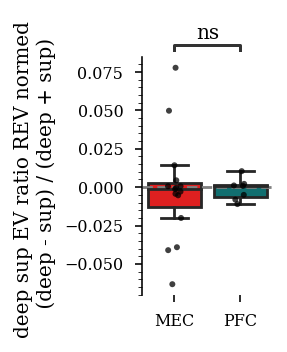

In [174]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))

df_wide.loc[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"

ax = sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["#de2020", "#116f70"],
            data=df_wide,showfliers=False,saturation=1)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k',size=3,alpha=.75)


sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("deep sup EV ratio REV normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='grey', linestyle='--')
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["MEC", "PFC"],
                    box_pairs=[("MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "explained_var_deep_sup_ratio_regions.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.499e-01 U_stat=2.800e+01
MEC_Deep v.s. MEC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.180e+02


(<AxesSubplot:xlabel='region', ylabel='$EV-REV$'>,
  <statannot.StatResult.StatResult at 0x2701baa3370>])

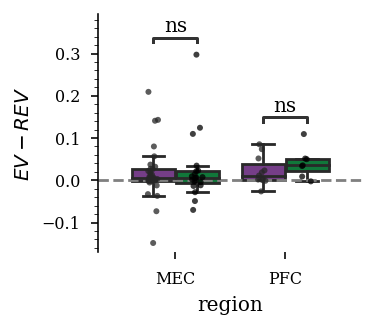

In [175]:
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))

fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

ev_df.loc[ev_df.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"

sns.boxplot(y="ev_norm", x="region",
            hue="sublayer", hue_order=group_colors.keys(),
            data=ev_df,showfliers=False)
sns.stripplot(y="ev_norm", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k',size=3,alpha=.75)
sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('$EV-REV$')
# plt.grid()
plt.axhline(0, color='grey', linestyle='--')
plt.legend("",
    frameon=False,
)
box_pairs=[(("MEC", "Deep"), ("MEC", "Superficial")),
                (("PFC", "Deep"), ("PFC", "Superficial")),
            ]
add_stat_annotation(plt.gca(), data=ev_df, y="ev_norm", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig(
#     os.path.join(fig_save_path, "explained_var_deep_sup_regions.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )